# General Index Data Framework

---
Created 6/3/22 by Ian Hay   
Updated 8/3/22

### Background
---

[The General Index](https://archive.org/details/GeneralIndex) is a massive public dataset produced by Public.Resource.Org, a research nonprofit lead by Carl Malamud. Data is obtained by parsing over 107 million research manuscripts and extrating key words and phrases that best represent the unberlying subject matter. In total, the set includes 35 billion rows of these [*n-grams*](https://en.wikipedia.org/wiki/N-gram) extracted using the python library [Spacy](https://spacy.io/), a premier natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) library.   

This Jupyter notebook aims to provide a framework for understanding and working with The General Index dataset without intense computational infrastructure or programming experience. A testing dataset, downloaded from [here (approximately 500kb)](https://ia902307.us.archive.org/18/items/GeneralIndex/data/), contains 4,098 n-ngrams across 768 manuscripts. It represents 0.00000115% of the total dataset. The data is extracted from manuscripts across 2 keywords: *Antediluvian*, or the historical era before the Biblical Flood, and *Hennig86*, a phylogenetic analysis computer program written in 1988 by James S. Farris.

[I wrote some thoughts](https://cooperative-stitch-bdc.notion.site/The-General-Index-and-Decentralized-Science-1a184bf6eebb4fdbb08b1d6c1b9db203) about the General Index and what it could be used for in the context of scientific publication. For this interested in a framework for NLP models trained on the General Index, head over to `2. data pipeline`. If you want to delve deeper and compare how different models performed on the data with varying hyperparameters, go to `3. pipeline optimization`.

### Imports
This section imports the necessary libraries and supplemental datasets to process the data.
Ensure to have a Python base environemnt with version >=3.8 and the necessary packages installed. It is highly recommended to download and install the packages in an [Anaconda environment](https://www.anaconda.com/).  

Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[nltk](https://www.nltk.org/)   
[spacy](https://pypi.org/project/spacy/)    
[matplotlib](https://matplotlib.org/)   

In [1]:
"""
Run this line in your python environment before running the code below:

conda install -c anaconda numpy scipy pandas nltk ssl spacy matplotlib scikit-learn

"""
import pandas as pd
import numpy as np
import nltk
import ssl
import spacy
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import CountVectorizer

/Users/ian/opt/anaconda3/envs/generalindexenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Run this line in your python environment before running the code below: 

python -m spacy download en_core_web_sm

"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /Users/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions
---
This section defines the functions used to process and utilize the data.

In [3]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBagOfWordsDF(df, docColumn):
    """
    Uses SKLearn's CountVectorizer to build a Bag-of-Words DataFrame
    for the given column. The column datatype should be formatted as 
    a document, where each document is a single string object.
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    Given a bag-of-words Pandas Dataframe, consructs a co-occurence
    matrix of size nxn, where n is the number of columns of the 
    Dataframe. Returns the matrix and a numpy array.
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

In [4]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Mean is 0, variance is 1
    """
    data = df[column]
    mean = np.mean(data)
    std = np.std(data)
    zScore = []
    for x in range(len(df.index)):
        zScore.append((data[x] - mean) / std)
    df[newColumnName] = zScore


### Building Dataframe and Processing Data
---

This section inputs the raw data into a Pandas Dataframe and preprocesses it to make the data more 
machine readable. It utilizes the Spacy to extract only the nouns, adjectives, verbs, and adverbs
from the ngrams, and NLTK to remove stopwords. It then groups the data by manuscript, stored in the raw data as a hash.

In [5]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antediluvian.txt"

In [6]:
"""
# load test files into dataframe (may take up to 1 minute)

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df_antedivulian["topic"] = "antediluvian"
df_hennig["topic"] = "hennig86"
df = pd.concat([df_antedivulian, df_hennig])

# save the data for later use
df.to_csv("test_data.csv")

# process data columns
df["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])
df["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])
# save the processed data
df.to_csv("test_data_processed.csv")

df = df.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "standardized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")
df["topic_num"] = (df["topic"] == "antediluvian").astype(int)

# save the dataframe for later use
df.to_csv("test_data_processed_grouped.csv")

df.head()
"""

'\n# load test files into dataframe (may take up to 1 minute)\n\nindexCol = columnListNGrams[0]\ndf_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)\ndf_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)\ndf_antedivulian["topic"] = "antediluvian"\ndf_hennig["topic"] = "hennig86"\ndf = pd.concat([df_antedivulian, df_hennig])\n\n# save the data for later use\ndf.to_csv("test_data.csv")\n\n# process data columns\ndf["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])\ndf["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])\n# save the processed data\ndf.to_csv("test_data_processed.csv")\n\ndf = df.groupby(indexCol).agg(list)\n\nyakeScoreCol = columnListNGrams[5]\nfor n in range(len(df)):\n    term_freq_list = df[yakeScoreCol].iloc[n]\n    df[yakeScoreCol].iloc[n] = term_freq_list[0]\n    df["topic"].iloc[n] = df["topic"].iloc[n][0]\n    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if the

In [7]:
# read the processed data CSV
df = pd.read_csv("test_data_processed_grouped.csv")
df.set_index("hash", inplace=True)
# https://stackoverflow.com/questions/63200863/how-to-convert-the-datatype-of-a-column-from-string-to-list-in-pandas
df['ngram'] = df['ngram'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc'] = df['ngram_lc'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc_tagged'] = df['ngram_lc_tagged'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df.head()

,ngram,ngram_lc,ngram_tokens,ngram_count,term_freq,doc_count,date_added,topic,ngram_lc_tagged,standardized_term_freq,ngram_lc_tagged_doc,ngram_lc_doc,topic_num
hash,,,,,,,,,,,,,
3002e8a37ec9d00a67bdf0004b8628c35d72068d,"[antediluvian, antediluvian humanity]","[antediluvian, antediluvian humanity]","['1', '2']","['1', '1']",0.000010,"['1', '1']","['\\N\n', '\\N\n']",antediluvian,"[antediluvian, antediluvian humanity]",-0.654965,antediluvian. antediluvian humanity.,antediluvian. antediluvian humanity.,1
3005b3bf055ddcb3c25e4742a72ee16728934efd,"[antediluvian, antediluvian refrain, follow by...","[antediluvian, antediluvian refrain, follow by...","['1', '2', '4', '5']","['1', '1', '1', '1']",0.000281,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",antediluvian,"[antediluvian, antediluvian refrain, follow an...",-0.004052,antediluvian. antediluvian refrain. follow ant...,antediluvian. antediluvian refrain. follow by ...,1
3005ebfe5508340797dbfcce8454f3d3f6f76eb1,"[antediluvian, antediluvian dream, cave of -PR...","[antediluvian, antediluvian dream, cave of -pr...","['1', '2', '4', '5', '5']","['1', '1', '1', '1', '1']",0.000091,"['1', '1', '1', '1', '1']","['2021-09-03\n', '2021-09-03\n', '2021-09-03\n...",antediluvian,"[antediluvian, antediluvian dream, cave antedi...",-0.459385,antediluvian. antediluvian dream. cave antedil...,antediluvian. antediluvian dream. cave of -pro...,1
30064ae161de1e9a96992be108c195796f13e72a,"[Hennig86 program, routine in the Hennig86, ro...","[hennig86 program, routine in the hennig86, ro...","['2', '4', '5', '1']","['1', '1', '1', '1']",0.000198,"['1', '1', '1', '1']","['\\N\n', '\\N\n', '\\N\n', '\\N\n']",hennig86,"[hennig86 program, routine hennig86, routine h...",-0.202622,hennig86 program. routine hennig86. routine he...,hennig86 program. routine in the hennig86. rou...,0
30136ab3788ab8e8be6b939901ec669a41ef896a,[antediluvian],[antediluvian],['1'],['1'],0.000051,['1'],['\\N\n'],antediluvian,[antediluvian],-0.556359,antediluvian.,antediluvian.,1


In [8]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

In [9]:
# count number of times each word appears in an ngram
dfBoW = getBagOfWordsDF(df, "ngram_lc_doc")
dfBoWTag = getBagOfWordsDF(df, "ngram_lc_tagged_doc")
wordCountDict = {}
wordCountDictTag = {}
for column in dfBoW.columns:
    wordCountDict[column] = np.sum(dfBoW[column])
for column in dfBoWTag.columns:
    wordCountDictTag[column] = np.sum(dfBoWTag[column])

In [10]:
# count number of times each ngram appears in the corpus
df_raw = pd.read_csv("test_data.csv")
df_tagged = pd.read_csv("test_data_processed.csv")
ngramDict = {}
ngramTaggedDict = {}
for n in range(len(df_raw.index)):
    ngram = df_raw["ngram_lc"][n]
    if ngram in list(ngramDict.keys()):
        ngramDict[ngram] = ngramDict[ngram] + 1
    else:
        ngramDict[ngram] = 1

for n in range(len(df_tagged.index)):
    ngram = str(df_tagged["ngram_lc_tagged"][n])
    if ngram in list(ngramTaggedDict.keys()):
        ngramTaggedDict[ngram] = ngramTaggedDict[ngram] + 1
    else:
        ngramTaggedDict[ngram] = 1

In [11]:
# count number of times ngrams of specified lengths appear
unigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 1)
bigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 2)
trigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 3)
fourgramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 4)
fivegramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 5)

# count number of times tagged ngrams of specified lengths appear
unigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 1)
bigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 2)
trigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 3)
fourgramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 4)
fivegramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 5)

### Data Visualization
---

With the General Index being composed of primarily natural language data in the form of words & phrases in the English language, it's important to understand the underlying content. To do this I prepared a few visualizations of the test dataset to understand the population of words describing research manuscripts across distinct topics.

In [12]:
# histogram of word counts
from collections import OrderedDict
# https://stackoverflow.com/questions/20577840/python-dictionary-sorting-in-descending-order-based-on-values
d_descending = OrderedDict(sorted(wordCountDict.items(), key=lambda kv: kv[1], reverse=True))
d_descending_df = pd.DataFrame(d_descending.values(), index = d_descending.keys(), columns=["word count"])
fig = px.bar(d_descending_df, y="word count", log_y = True, title='Counts of top words', template='seaborn', color_discrete_sequence=["red"])
fig.show()

# histogram of top tagged word counts
d_descending_tagged = OrderedDict(sorted(wordCountDictTag.items(), key=lambda kv: kv[1], reverse=True))
d_descending_tagged_df = pd.DataFrame(d_descending_tagged.values(), index=d_descending_tagged.keys(), columns=["word count"])
fig = px.bar(d_descending_tagged_df, y="word count", log_y = True, title='Counts of top tagged words', template='seaborn', color_discrete_sequence=["red"])
fig.show()

This first takes a look at the number of times each word appears in a manuscript's n-grams. Both the raw and preprocessed datasets show highly skewed data with Antediluvian as the most common word. It appears the preprocessed data shows slightly more meaningful words in the less common words, although only a small portion of words are shown.

---

In [13]:
# histogram of top N words
N = 20
fig = px.bar(d_descending_df.head(N), y="word count", log_y = False, title='Counts of top ' +  str(N) + ' words', template='plotly_white')
fig.show()

# histogram of top N tagged words
fig = px.bar(d_descending_tagged_df.head(N), y="word count", log_y = False, title='Counts of top ' +  str(N) + ' tagged words', template='plotly_white')
fig.show()

Looking at the top 20 words, the most common words of the preprocessed words have more meaning to the underlying topic than the raw data. However for NLP modeling, its important to consider that you may not want to remove common words like "of", "in", "with" etc. as they can offer important context and some models are context-sensitive.

---

In [14]:
# histogram of term_freq
termFreqDict = {}
for index in df.index:
    termFreqDict[index] = df["term_freq"].loc[index]
termFreq_descending = OrderedDict(sorted(termFreqDict.items(), key=lambda kv: kv[1], reverse=True))
termFreqDF = pd.DataFrame(termFreq_descending.values(), columns=["term freq"])
fig = px.bar(termFreqDF, y="term freq", log_y = True, title='Counts of ngram term frequency in underlying manuscript', template='plotly_white')
fig.show()

# histogram of number of ngrams per document

lenDict = {}
for x in range(len(df.index)):
    lenDict[df.index[x]] = len(df["ngram_lc"][x])
lenDict_descending = OrderedDict(sorted(lenDict.items(), key=lambda kv: kv[1], reverse=True))
lenDictDf = pd.DataFrame(lenDict_descending.values(), columns=["ngram counts"])
fig = px.bar(lenDictDf, y="ngram counts", log_y = True, title='Counts of ngrams associated with a particular manuscript', template='plotly_white')
fig.show()

# histogram of number of tagged ngrams per document

lenDict = {}
for x in range(len(df.index)):
    lenDict[df.index[x]] = len(df["ngram_lc_tagged"][x])
lenDict_descending = OrderedDict(sorted(lenDict.items(), key=lambda kv: kv[1], reverse=True))
lenDictDf = pd.DataFrame(lenDict_descending.values(), columns=["ngram counts"])
fig = px.bar(lenDictDf, y="ngram counts", log_y = True, title='Counts of tagged ngrams associated with a particular manuscript', template='plotly_white')
fig.show()

It appears the preprocessing does not alter the number of ngrams associated with a particular manuscript based on the similarity between the two bottom histograms. 

---

In [15]:
# plot top N unigrams
N = 20
unigramDict_descending = OrderedDict(sorted(unigramDict.items(), key = lambda kv: kv[1], reverse=True))
unigramDfDescending = pd.DataFrame(unigramDict_descending.values(), index=unigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(unigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' unigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N bigrams
bigramDict_descending = OrderedDict(sorted(bigramDict.items(), key = lambda kv: kv[1], reverse=True))
bigramDfDescending = pd.DataFrame(bigramDict_descending.values(), index=bigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(bigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' bigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N trigrams
trigramDict_descending = OrderedDict(sorted(trigramDict.items(), key = lambda kv: kv[1], reverse=True))
unigramDfDescending = pd.DataFrame(trigramDict_descending.values(), index=trigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(unigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' trigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N 4grams
fourgramDict_descending = OrderedDict(sorted(fourgramDict.items(), key = lambda kv: kv[1], reverse=True))
fourgramDfDescending = pd.DataFrame(fourgramDict_descending.values(), index=fourgramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(fourgramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' 4grams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N 5grams
fivegramDict_descending = OrderedDict(sorted(fivegramDict.items(), key = lambda kv: kv[1], reverse=True))
fivegramDfDescending = pd.DataFrame(fivegramDict_descending.values(), index=fivegramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(fivegramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' 5grams associated with a particular manuscript', template='plotly_white')
fig.show()

In [16]:
# plot top N tagged unigrams
N = 20
unigramDict_descending = OrderedDict(sorted(unigramDictTagged.items(), key = lambda kv: kv[1], reverse=True))
unigramDfDescending = pd.DataFrame(unigramDict_descending.values(), index=unigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(unigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' tagged unigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N tagged bigrams
bigramDict_descending = OrderedDict(sorted(bigramDictTagged.items(), key = lambda kv: kv[1], reverse=True))
bigramDfDescending = pd.DataFrame(bigramDict_descending.values(), index=bigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(bigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' tagged bigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N tagged trigrams
trigramDict_descending = OrderedDict(sorted(trigramDictTagged.items(), key = lambda kv: kv[1], reverse=True))
unigramDfDescending = pd.DataFrame(trigramDict_descending.values(), index=trigramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(unigramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' tagged trigrams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N tagged 4grams
fourgramDict_descending = OrderedDict(sorted(fourgramDictTagged.items(), key = lambda kv: kv[1], reverse=True))
fourgramDfDescending = pd.DataFrame(fourgramDict_descending.values(), index=fourgramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(fourgramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' tagged 4grams associated with a particular manuscript', template='plotly_white')
fig.show()

# plot top N tagged 5grams
fivegramDict_descending = OrderedDict(sorted(fivegramDictTagged.items(), key = lambda kv: kv[1], reverse=True))
fivegramDfDescending = pd.DataFrame(fivegramDict_descending.values(), index=fivegramDict_descending.keys() ,columns=["ngram counts"])
fig = px.bar(fivegramDfDescending.head(N), y="ngram counts", log_y = False, title='Counts of top ' + str(N) + ' tagged 5grams associated with a particular manuscript', template='plotly_white')
fig.show()

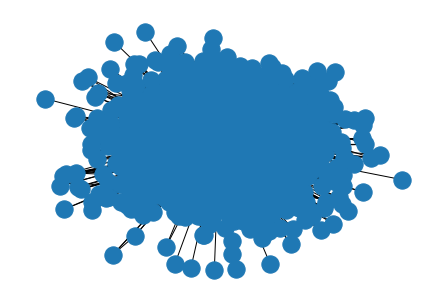

<Figure size 5400x2700 with 0 Axes>

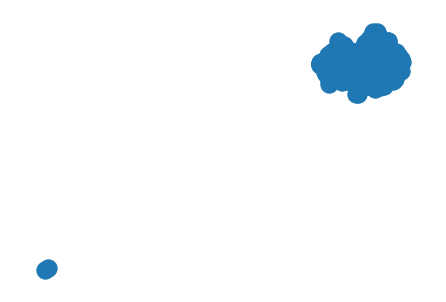

In [22]:
# visualize the manuscripts by co-occurence of words stored in ngrams
# need to beautify a bit
import networkx as nx
from matplotlib.pyplot import figure

adjMatrix = buildAdjacencyMatrixByCoOccurence(dfBoW)
adjMatrixTagged = buildAdjacencyMatrixByCoOccurence(dfBoWTag)
G = nx.from_numpy_matrix(adjMatrix)
nx.draw(G)
figure(figsize=(18,9), dpi=300)
plt.show()
G = nx.from_numpy_matrix(adjMatrixTagged)
nx.draw(G)
plt.show()
